# Topic Modeling the Headline News with Latent Dirichilet Allocation

## Package Denpendencies

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE


[nltk_data] Downloading package stopwords to /Users/eric/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/eric/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Configurations



In [2]:
file_path = "./abcnews-date-text.csv"

sample_num = 1164946
topic_num = 34

stemmer = SnowballStemmer(language='english')
stop_words = set(stopwords.words('english'))
punctuations = string.punctuation

# Testing
print(word_tokenize("What is your name"), 'is' in stop_words)
print(stemmer.stem("difference"), stemmer.stem("justify"), stemmer.stem("running"))

['What', 'is', 'your', 'name'] True
differ justifi run


## Data Preprepartion

### Load and display the data

In [3]:
df = data = pd.read_csv(file_path, skiprows=[i for i in range(1,sample_num)])
print(df.head(10))

   publish_date                                      headline_text
0      20190517  nrl panthers warriors broncos roosters scorece...
1      20190517              nrl responds to jack de belin verdict
2      20190517  nurse sentenced to community service over botc...
3      20190517  olympic cyclist jack bobridge found guilty of ...
4      20190517  one hour workers one hour employment jobs unem...
5      20190517    one punch attacker sentenced over act caught on
6      20190517         one punch attacker sentenced to five years
7      20190517            paul keating reflects hawke era reforms
8      20190517  people who own guns illegally cause the gun crime
9      20190517  perth father admits sleepover sexual abuse chi...


### Display and clear the repetitions if any


In [4]:
df[df['headline_text'].duplicated(keep=False)]\
      .sort_values('headline_text').head(10)
df_norep = df.drop_duplicates('headline_text')

### Pick up sample_num (defined at [Configurations](#scrollTo=SHRdUgeGDXEH&line=1&uniqifier=1)) of headlines 

In [5]:
# data = df_norep.sample(n=sample_num, axis=0)
text_data = df['headline_text'].copy(deep=True)
text_data.head(10)

0    nrl panthers warriors broncos roosters scorece...
1                nrl responds to jack de belin verdict
2    nurse sentenced to community service over botc...
3    olympic cyclist jack bobridge found guilty of ...
4    one hour workers one hour employment jobs unem...
5      one punch attacker sentenced over act caught on
6           one punch attacker sentenced to five years
7              paul keating reflects hawke era reforms
8    people who own guns illegally cause the gun crime
9    perth father admits sleepover sexual abuse chi...
Name: headline_text, dtype: object

### Clear the stop words, replace the words in headlines with their stem word, and clear the punctiations.

In [6]:
def processor(text):
    # for punctuation in punctuations:
    #     text = text.replace(punctuation, '')
    # text = text.lower()
    text = [word for word in word_tokenize(text) if not word in stop_words]
    text = [stemmer.stem(word) for word in text]
    return " ".join(text)

# Test
processor("This is a good beginning. So be happy.")

'this good begin . so happi .'

In [7]:
from tqdm import tqdm

for idx in tqdm(data.index):
    text_data[idx] = processor(text_data[idx])

text_data.head(10)

100%|██████████| 61313/61313 [00:06<00:00, 9890.51it/s] 


0        nrl panther warrior bronco rooster scorecentr
1                    nrl respond jack de belin verdict
2    nurs sentenc communiti servic botch breast sur...
3    olymp cyclist jack bobridg found guilti drug deal
4         one hour worker one hour employ job unemploy
5                  one punch attack sentenc act caught
6                   one punch attack sentenc five year
7                    paul keat reflect hawk era reform
8                       peopl gun illeg caus gun crime
9    perth father admit sleepov sexual abus child p...
Name: headline_text, dtype: object

### Calculate the Count Vector and Tfidf Vector

In [8]:
CountVectorizer().fit_transform(text_data).shape

(61313, 22772)

In [9]:
vect = TfidfVectorizer()
X = vect.fit_transform(text_data).toarray()
tfidf_features = vect.get_feature_names_out()
X = pd.DataFrame(X, columns=tfidf_features)
X

,000,007,01,0107,0108,02,0212,03,04,0401,...,zonfrillo,zoo,zoodoo,zookeep,zoom,zou,zuckerberg,zuhbi,zuma,zverev
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61309,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Topic Modeling

### Build and fit the NMF model

In [10]:
model = NMF(n_components=topic_num, init="nndsvd", max_iter=500, random_state=1)
nmf_features = model.fit_transform(X)

### Display the outputs

In [11]:
# Display the output features
nmf_features

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 2.22922238e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.05375047e-03, 7.20385950e-04, 3.36385599e-04],
       [7.95584369e-04, 4.01004280e-05, 1.08669462e-03, ...,
        8.57142291e-03, 1.94492967e-03, 0.00000000e+00],
       ...,
       [1.92915602e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.05321308e-02, 0.00000000e+00],
       [7.51909505e-04, 0.00000000e+00, 5.33731817e-02, ...,
        3.35757334e-03, 0.00000000e+00, 8.89774571e-04],
       [3.10418451e-03, 1.83249740e-04, 3.78613839e-03, ...,
        4.71134752e-03, 3.12975794e-03, 3.12212939e-05]])

In [12]:
# Build the word(token) matrix as a Dataframe
components_df = pd.DataFrame(model.components_, columns=vect.get_feature_names_out())
components_df

,000,007,01,0107,0108,02,0212,03,04,0401,...,zonfrillo,zoo,zoodoo,zookeep,zoom,zou,zuckerberg,zuhbi,zuma,zverev
0,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,0.011321,0.000000,0.000000,0.006040,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000001,0.000000,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,0.000724,0.000000,0.000000,0.000454,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000001,0.000000,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000292,0.000000,0.000010,0.0,0.000000e+00,0.000000,0.000000e+00,0.000018,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000031,0.000000,0.000044,0.000170,0.000000
5,0.000712,0.000000,0.000000,0.0,1.539810e-06,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000057,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000,3.008636e-06,0.000000,0.000000,1.115017e-06,...,0.000000,0.007084,0.000000,0.000000,0.004400,0.000036,0.000000,0.000000,0.001424,0.000000
7,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000004,0.000000,0.000000,0.000000,0.000000
9,0.002338,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Display the Modelling effects

### The 10 words with the highest values of each topic

In [13]:
for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print("Topic {:>2}: ".format(topic), end="")
    top_words = tmp.nlargest(10)
    for i in range(10):
        print("{:>11}*{:>3.2f}".format(top_words.index[i], top_words[i]), end=" ")
    print()

Topic  0: coronavirus*8.81      pandem*0.65        case*0.54     covid19*0.52       updat*0.48        amid*0.44    lockdown*0.39    outbreak*0.36      school*0.34      vaccin*0.30 
Topic  1:         abc*2.27        news*2.24       stori*2.03         top*2.01        quiz*0.17     headlin*0.10      latest*0.07       rural*0.06      region*0.05        make*0.05 
Topic  2:       covid*2.66          19*2.39      vaccin*0.21      pandem*0.17      latest*0.14        news*0.07          uk*0.06    outbreak*0.05    lockdown*0.05     cluster*0.04 
Topic  3:      financ*2.27      kohler*2.16        alan*2.16    thursday*0.57   wednesday*0.56     tuesday*0.53      monday*0.51      friday*0.25      lasker*0.21     phillip*0.20 
Topic  4:       trump*3.56      donald*2.91       biden*0.51     impeach*0.51         joe*0.37      presid*0.29       white*0.14        hous*0.14        call*0.14  republican*0.11 
Topic  5:       polic*9.25       offic*2.20    investig*1.46       shoot*1.03          nt*1.03 

### Count number of headlines be categorized into each topic

Text(0, 0.5, 'Number of headlines')

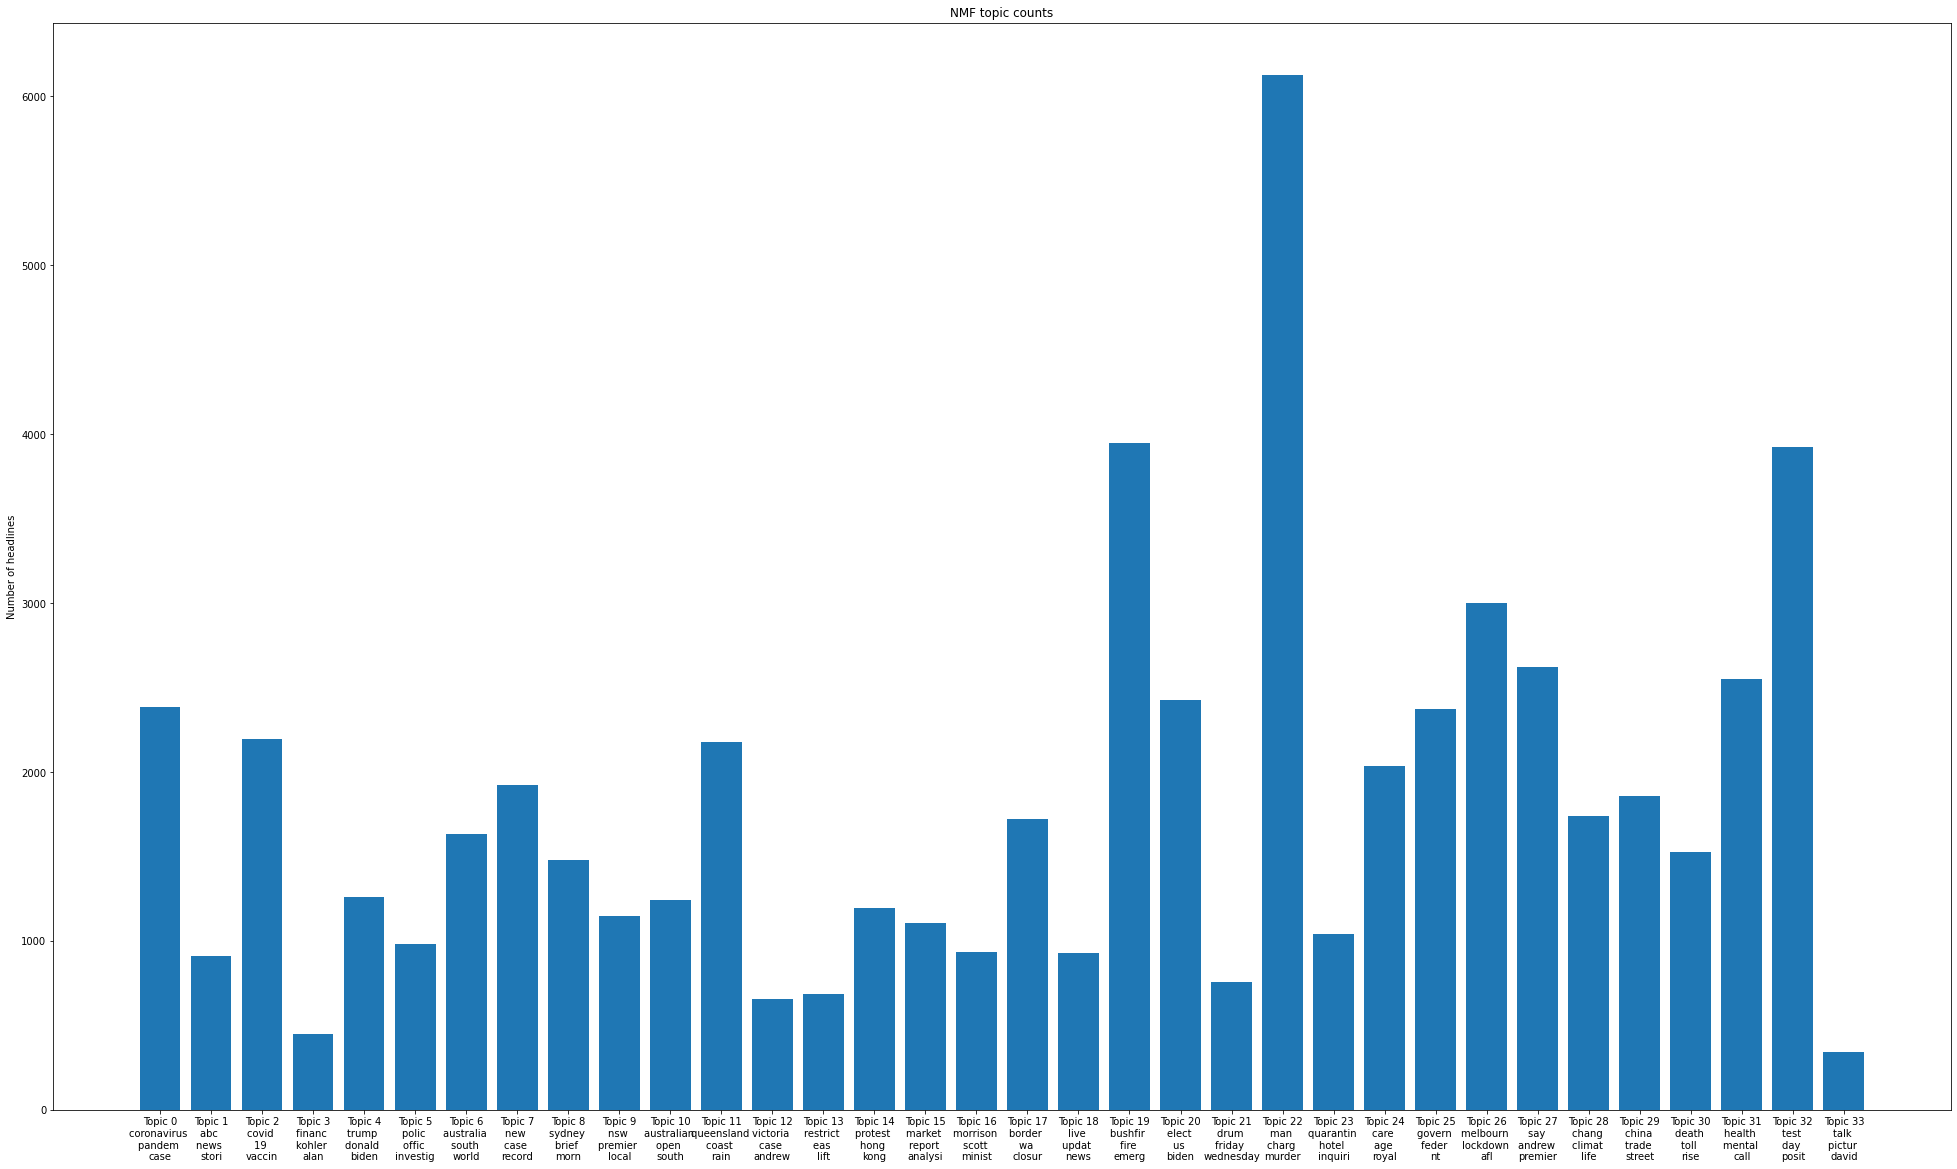

In [14]:
labels = []
counts = [0]*topic_num
# Calculate the 3 words(tokens) with the highest value as the x tick label
for topic in range(topic_num):
    top_words = components_df.iloc[topic].nlargest(3)
    labels.append("Topic {}\n{} \n{} \n{}".format(topic, top_words.index[0],
            top_words.index[1],top_words.index[2]))

# Calculate the number of headlines in each topic
for idx in range(nmf_features.shape[0]):
    counts[nmf_features[idx].argmax()] += 1

_, ax = plt.subplots(figsize=(topic_num, 20))
ax.bar(range(topic_num), counts)
ax.set_xticks(range(topic_num))
ax.set_xticklabels(labels)
ax.set_title('NMF topic counts')
ax.set_ylabel('Number of headlines')


### Draw the t-SNE Clustering of the Topics

In [15]:

sampled_feat_idx = np.random.choice(
    np.array([i for i in range(nmf_features.shape[0])]), size=10000, replace=True)

tsne_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2500, verbose=1, init='random', angle=0.75)
tsne_vectors = tsne_model.fit_transform(nmf_features[sampled_feat_idx])

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.008s...
[t-SNE] Computed neighbors for 10000 samples in 1.190s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.002074
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.693535
[t-SNE] KL divergence after 2500 iterations: 0.872703


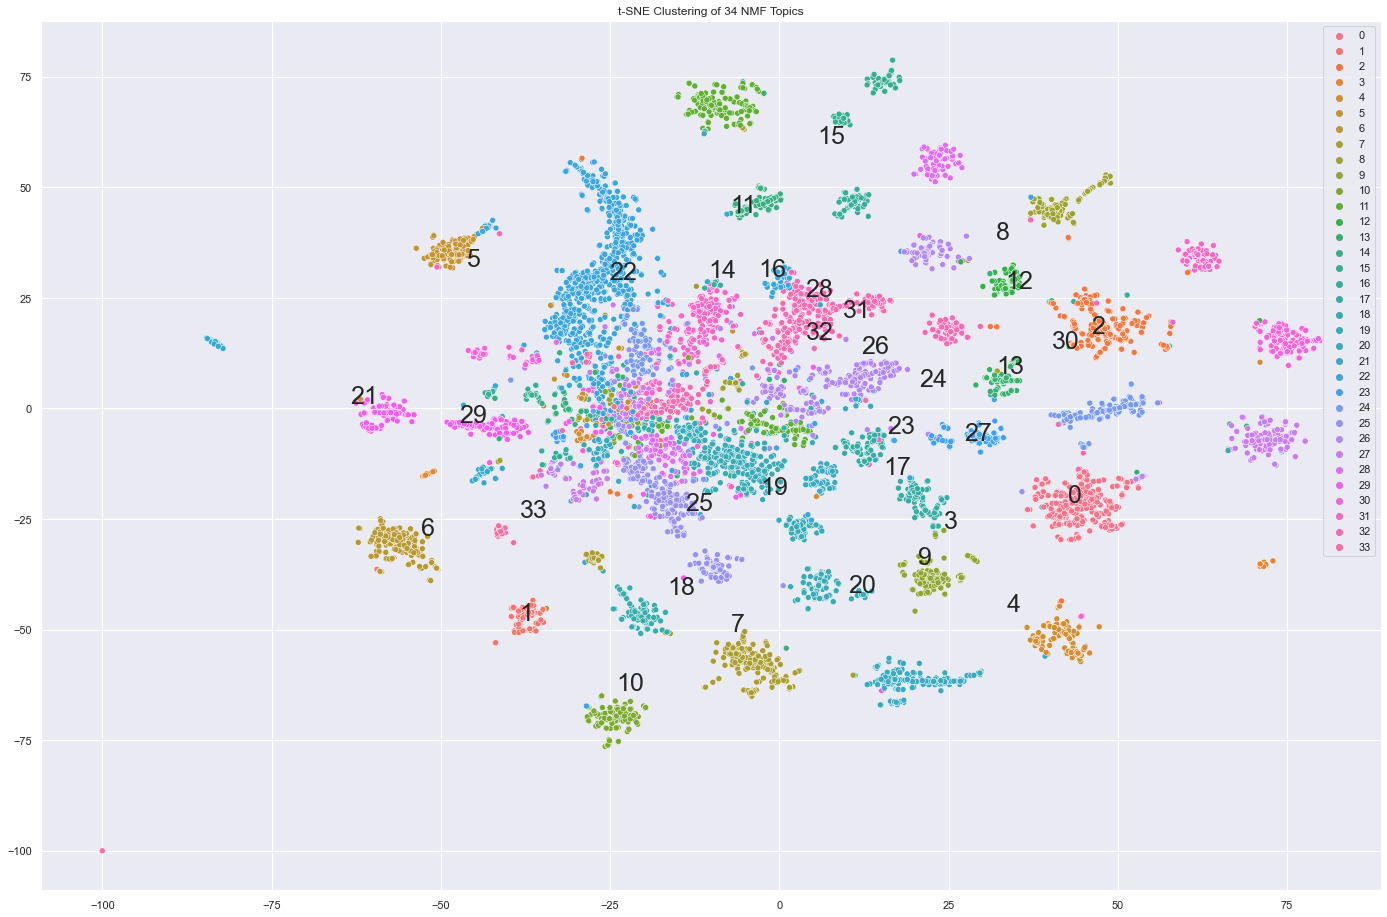

In [16]:
# Assign a label to each topic and reformat the tsne feature matrix to calculate the mean
tsne_label = [str(i) for i in range(topic_num)]
tsne_vec_re = [[[], []] for i in range(topic_num)]
for (idx, feat_idx) in enumerate(sampled_feat_idx):
    topic = nmf_features[feat_idx].argmax()
    tsne_label.append("{}".format(topic))
    tsne_vec_re[topic][0].append(tsne_vectors[idx][0])
    tsne_vec_re[topic][1].append(tsne_vectors[idx][1])

# Use a placeholder(add a outlier (-100, -100) for each topic) 
# to make the label displayed in order
placeholder = np.array([[-100, -100]]*topic_num)
tsne_vectors_ = np.concatenate((placeholder, tsne_vectors), axis=0)
    
# Display the t-SNE plot
sns.set(rc={'figure.figsize':(24,16)})
plt.title("t-SNE Clustering of {} NMF Topics".format(topic_num))
sns.scatterplot(x = tsne_vectors_[:,0], y = tsne_vectors_[:,1],
                 hue=tsne_label, legend='full')

# Define a mean function of a list
def mean(x):
    return sum(x)/len(x)

# Put the topic text to the cluster, the position is the mean 
# vector of all headlines in the cluster
for topic in range(topic_num):
    x, y = mean(tsne_vec_re[topic][0]), mean(tsne_vec_re[topic][1])
    plt.text(x, y, tsne_label[topic], fontsize = 25)